* [Section 1](#Section-one)
     * [Section (1.a)](#subsection-one-of-section-1)
     * [Section (1.b)](#subsection-two-of-section-1)

In [2]:
pip install tfimm

  Obtaining dependency information for tfimm from https://files.pythonhosted.org/packages/2b/58/da31a94293d086b353555d36d00eba9cb8c92fa85f161f2a27db9a9488cd/tfimm-0.2.14-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.9/225.9 kB 3.7 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


# *Importing Libraries* <a class="anchor"  id="1"></a>

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate, Dense, BatchNormalization, Flatten, MaxPooling2D, Dropout, Conv2D, Reshape
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adamax, Nadam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# import tfimm

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# *Data* <a class="anchor"  id="Data"></a>

## *Create DataFrame* <a class="anchor"  id="CreateDataFrame"></a>

In [3]:
dataset_path = '/kaggle/input/nasal-bone-dataset/Dataset - v4'

paths = []
labels = []

for phase in ['train', 'validation', 'test']:
    phase_path = os.path.join(dataset_path, phase)
    
    for category in ['normal', 'fracture']:
        category_path = os.path.join(phase_path, category)

        for folder_name in os.listdir(category_path):
            folder_path = os.path.join(category_path, folder_name)

            if os.path.isdir(folder_path):
                for image_name in ['R', 'L']:
                    image_path = os.path.join(folder_path, f'{image_name}.jpg')

                    if os.path.exists(image_path):
                        paths.append(image_path)
                        labels.append(category)

                    
df = pd.DataFrame({'image_path': paths, 'label': labels})
df.head()

,image_path,label
0,/kaggle/input/nasal-bone-dataset/Dataset - v4/...,normal
1,/kaggle/input/nasal-bone-dataset/Dataset - v4/...,normal
2,/kaggle/input/nasal-bone-dataset/Dataset - v4/...,normal
3,/kaggle/input/nasal-bone-dataset/Dataset - v4/...,normal
4,/kaggle/input/nasal-bone-dataset/Dataset - v4/...,normal


In [4]:
df.shape

(2968, 2)

## Read Images <a class="anchor"  id="ReadImages"></a>

In [5]:
def read_images_from_df(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        img = img[:img.shape[1], :]
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

images, labels = read_images_from_df(df)

In [ ]:
train_df = df[df['image_path'].str.contains('train')]
validation_df = df[df['image_path'].str.contains('validation')]
test_df = df[df['image_path'].str.contains('test')]

In [5]:
print("Train DataFrame Shape:      ", train_df.shape)
print("Validation DataFrame Shape: ", validation_df.shape)
print("Test DataFrame Shape:       ", test_df.shape)

Train DataFrame Shape:       (2076, 2)
Validation DataFrame Shape:  (446, 2)
Test DataFrame Shape:        (446, 2)


In [6]:
def read_images_from_df(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

train_images, train_labels = read_images_from_df(train_df)
validation_images, validation_labels = read_images_from_df(validation_df)
test_images, test_labels = read_images_from_df(test_df)

# *Preprocessing*

In [6]:
def gaussian_noise(image):
    mean=0
    std=5
    noise = np.random.normal(mean, std, image.shape)
    
    noisy_image = image + noise
    
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(np.uint8)
    
    return noisy_image

In [7]:
def sharpen_image(image, kernel_size=(3, 3), strength=0.1):
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    sharpened = cv2.filter2D(image, -1, kernel)

    sharpened = cv2.addWeighted(image, 1 + strength, sharpened, -strength, 0)

    return sharpened

In [8]:
def preprocessing(img):
    img = img[:img.shape[1], :]
    
    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray_image)
    
    sharp1 = sharpen_image(cl1)
    
    sharp1 = 1 - sharp1

    sharp2 = sharpen_image(sharp1)
    
    rgb = cv2.cvtColor(sharp2, cv2.COLOR_GRAY2RGB)

    rgb = 1 - rgb
    
    noise = gaussian_noise(rgb)

    return noise

In [10]:
for i in range (len(train_images)):
    train_images[i] = preprocessing(train_images[i])

for i in range (len(validation_images)):
    validation_images[i] = preprocessing(validation_images[i])

for i in range (len(test_images)):
    test_images[i] = preprocessing(test_images[i])

NameError: name 'train_images' is not defined

In [9]:
for i in range (len(images)):
    images[i] = preprocessing(images[i])

## *Split data on train val test*

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(np.asarray(images), np.asarray(labels), test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [11]:
print("shape of X_train is: {} ".format(X_train.shape))
print("shape of X_val is: {}".format(X_val.shape))
print("shape of X_test is: {}".format(X_test.shape))
print()
print("shape of y_train is: {} ".format(y_train.shape))
print("shape of y_val is: {}".format(y_val.shape))
print("shape of y_test is: {}".format(y_test.shape))

shape of X_train is: (2077, 224, 224, 3) 
shape of X_val is: (445, 224, 224, 3)
shape of X_test is: (446, 224, 224, 3)

shape of y_train is: (2077,) 
shape of y_val is: (445,)
shape of y_test is: (446,)


In [12]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    brightness_range=[0.8, 1.3],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1./255) 

test_datagen = ImageDataGenerator(rescale=1./255) 



# Create generator for training data
train_generator = train_datagen.flow(
    np.array(X_train), 
    y_train, 
    batch_size=batch_size,
    shuffle=True,
)

# Create generator for Validation data
validation_generator = validation_datagen.flow(
    np.array(X_val),
    y_val,
    batch_size=batch_size,
    shuffle=False,  
)

# Create generator for Test data
test_generator = test_datagen.flow(
    np.array(X_test),
    y_test,
    batch_size=batch_size,
    shuffle=False,  
)

In [11]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    brightness_range=[0.8, 1.3],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1./255) 

test_datagen = ImageDataGenerator(rescale=1./255) 



# Create generator for training data
train_generator = train_datagen.flow(
    np.array(train_images), 
    train_labels, 
    batch_size=batch_size,
    shuffle=True,
)

# Create generator for Validation data
validation_generator = validation_datagen.flow(
    np.array(validation_images),
    validation_labels,
    batch_size=batch_size,
    shuffle=False,  
)

# Create generator for Test data
test_generator = test_datagen.flow(
    np.array(test_images),
    test_labels,
    batch_size=batch_size,
    shuffle=False,  
)

In [13]:
classes = np.unique(labels)
classes

array([0, 1])

In [14]:
img, lable = train_generator.next()
img.shape

(16, 224, 224, 3)

### Show sample:

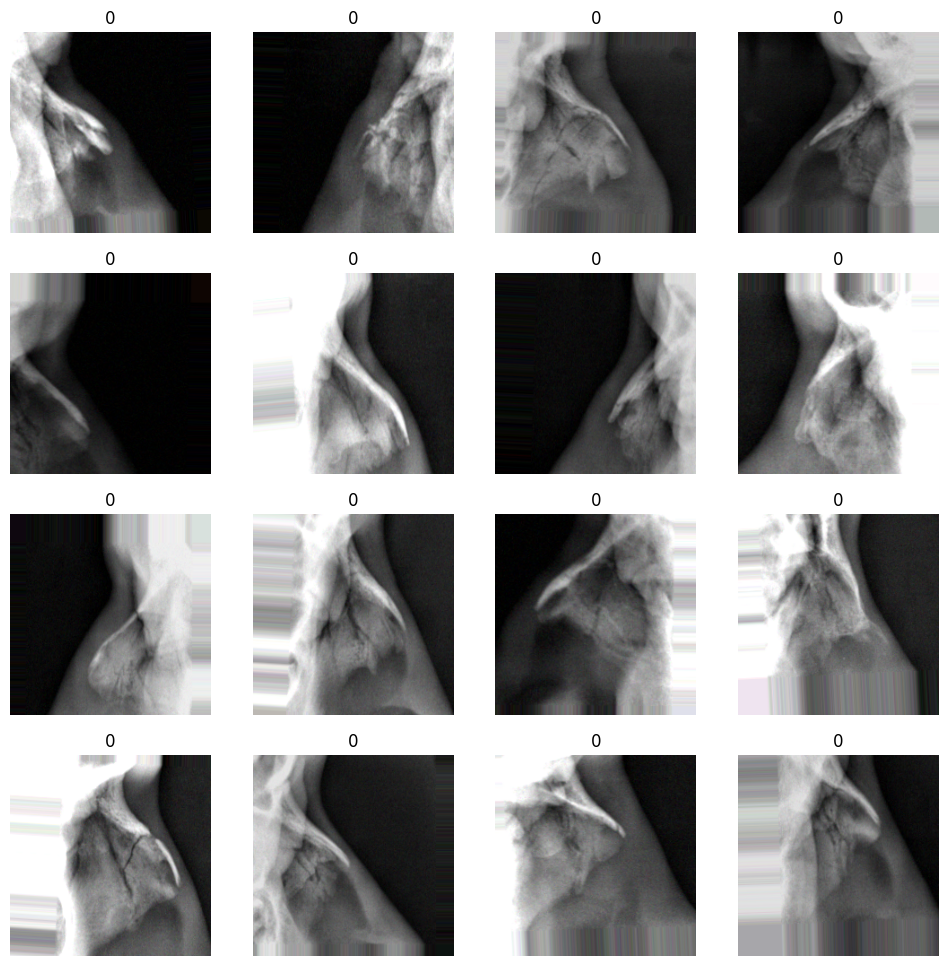

In [15]:
def show_sample(img, lable):
    plt.figure(figsize= (12, 12))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        index = np.argmax(lable[i]) 
        class_name = classes[index]
        plt.title(class_name)
        plt.axis('off')
    plt.show()
    
show_sample(img, lable)

In [15]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='darkblue')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='darkblue')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()
    
    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss))) 

In [16]:
# global parameters:
EPOCHS = 50
IMG_SHAPE = (224, 224, 3)
LR = 5e-4
OPTIMIZER = tf.keras.optimizers.legacy.Adamax(LR)
LOSS = SparseCategoricalCrossentropy()
METRICS = ['accuracy']

In [17]:
def lr_schedule(epoch):
    initial_learning_rate = LR
    decay = 0.95
    lr = initial_learning_rate * decay**(1.25 * epoch)
    if lr > 1e-4:
        return lr
    else:
        return 1e-4

In [18]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [19]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Path to save the model file
    monitor='val_accuracy',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max'                 # Mode can be 'min', 'max', or 'auto'
)

# *Model Structure*
## *Convolutional Neural Network*
### *Using Transfer Learning...*

In [29]:
tfimm.list_models(pretrained=True)

['cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 '

In [127]:
url = "vgg16"

base_model = tfimm.create_model(url, pretrained=True)

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [128]:
dummy_input = np.random.rand(1, 224, 224, 3)
output = base_model.predict(dummy_input)
print(output.shape)

1/1 [==============================] - 1s 870ms/step
(1, 1000)


In [129]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features/0 (Conv2D)         multiple                  1792      
                                                                 
 features/1 (Activation)     multiple                  0         
                                                                 
 features/2 (Conv2D)         multiple                  36928     
                                                                 
 features/3 (Activation)     multiple                  0         
                                                                 
 features/4 (MaxPooling2D)   multiple                  0         
                                                                 
 features/5 (Conv2D)         multiple                  73856     
                                                                 
 features/6 (Activation)     multiple                  0     

In [130]:
# Define layer names to remove
layers_to_remove = ['head']

# Get the original model's layers except those to be removed
layers_to_keep = [layer for layer in base_model.layers if layer.name not in layers_to_remove]

# Create a new model with the remaining layers
base_model = Sequential(name="vit_base_patch8_224")

# Add the layers to the new model
for layer in layers_to_keep:
    base_model.add(layer)

In [131]:
base_model.build((1,224,224,3))
# Print the new model summary
base_model.summary()

Model: "vit_base_patch8_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features/0 (Conv2D)         (1, 224, 224, 64)         1792      
                                                                 
 features/1 (Activation)     (1, 224, 224, 64)         0         
                                                                 
 features/2 (Conv2D)         (1, 224, 224, 64)         36928     
                                                                 
 features/3 (Activation)     (1, 224, 224, 64)         0         
                                                                 
 features/4 (MaxPooling2D)   (1, 112, 112, 64)         0         
                                                                 
 features/5 (Conv2D)         (1, 112, 112, 128)        73856     
                                                                 
 features/6 (Activation)     (1, 112, 112, 128)

In [132]:
base_model.trainable = True
print("Number of layers in the base_model: ", len(base_model.layers))

Number of layers in the base_model:  32


In [133]:
for layer in base_model.layers[:12]:
    layer.trainable = False

In [134]:
dummy_input = np.random.rand(16, 224, 224, 3)
output = base_model.predict(dummy_input)
print(output.shape)

1/1 [==============================] - 2s 2s/step
(16, 1, 1, 4096)


---

In [20]:
from tensorflow.keras.applications import VGG16, ResNet101V2, InceptionV3, MobileNetV3Large, ResNet50V2, Xception, InceptionResNetV2, DenseNet121, MobileNetV2

In [84]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

base_model.trainable = True
print("Number of layers in the base_model: ", len(base_model.layers))

29084464/29084464 [==============================] - 0s 0us/step
Number of layers in the base_model:  427


In [85]:
for layer in base_model.layers[:250]:
    layer.trainable = False

In [23]:
thrsh = 0.35

## VGG16:

In [42]:
expert1 = VGG16(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert1.trainable = True
print("Number of layers in the expert1: ", len(expert1.layers))

for layer in expert1.layers[:int(len(expert1.layers) * thrsh)]:
    layer.trainable = False

Number of layers in the expert1:  19


## ResNet101V2

In [43]:
expert2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert2.trainable = True
print("Number of layers in the expert2: ", len(expert2.layers))

for layer in expert2.layers[:int(len(expert2.layers) * thrsh)]:
    layer.trainable = False

Number of layers in the expert2:  377


## InceptionV3

In [44]:
expert3 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert3.trainable = True
print("Number of layers in the expert3: ", len(expert3.layers))

for layer in expert3.layers[:int(len(expert3.layers) * thrsh)]:
    layer.trainable = False

Number of layers in the expert3:  780


## MobileNetV3Large

In [45]:
expert4 = Xception(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert4.trainable = True
print("Number of layers in the expert4: ", len(expert4.layers))

for layer in expert4.layers[:int(len(expert4.layers) * thrsh)]:
    layer.trainable = False

Number of layers in the expert4:  132


In [60]:
def build_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    
    # VGG16
    conv1 = expert1(input_img)
    flat1 = Flatten()(conv1)
    drop1_1 = Dropout(0.5)(flat1)
    bn1_1 = BatchNormalization()(drop1_1)
    dense1_1 = Dense(256, 'relu')(bn1_1)
    drop1_2 = Dropout(0.5)(dense1_1)
    bn1_2 = BatchNormalization()(drop1_2)
    
    dense1_2 = Dense(64, 'relu')(bn1_2)
    drop1_3 = Dropout(0.3)(dense1_2)
    bn1_3 = BatchNormalization()(drop1_3)
#     output_expert1 = Dense(len(classes), "sigmoid")(bn1_3)

    # ResNet101V2
    conv2 = expert2(input_img)
    flat2 = Flatten()(conv2)
    drop2_1 = Dropout(0.5)(flat2)
    bn2_1 = BatchNormalization()(drop2_1)
    dense2_1 = Dense(256, 'relu')(bn2_1)
    drop2_2 = Dropout(0.5)(dense2_1)
    bn2_2 = BatchNormalization()(drop2_2)
    
    dense2_2 = Dense(64, 'relu')(bn2_2)
    drop2_3 = Dropout(0.3)(dense2_2)
    bn2_3 = BatchNormalization()(drop2_3)
#     output_expert2 = Dense(len(classes), "sigmoid")(bn2_3)

    # InceptionV3
    conv3 = expert3(input_img)
    flat3 = Flatten()(conv3)
    drop3_1 = Dropout(0.5)(flat3)
    bn3_1 = BatchNormalization()(drop3_1)
    dense3_1 = Dense(256, 'relu')(bn3_1)
    drop3_2 = Dropout(0.5)(dense3_1)
    bn3_2 = BatchNormalization()(drop3_2)
    
    dense3_2 = Dense(64, 'relu')(bn3_2)
    drop3_3 = Dropout(0.3)(dense3_2)
    bn3_3 = BatchNormalization()(drop3_3)
#     output_expert3 = Dense(len(classes), "sigmoid")(bn3_3)

    # MobileNetV3Large
    conv4 = expert4(input_img)
    flat4 = Flatten()(conv4)
    drop4_1 = Dropout(0.5)(flat4)
    bn4_1 = BatchNormalization()(drop4_1)
    dense4_1 = Dense(256, 'relu')(bn4_1)
    drop4_2 = Dropout(0.5)(dense4_1)
    bn4_2 = BatchNormalization()(drop4_2)
    
    dense4_2 = Dense(64, 'relu')(bn4_2)
    drop4_3 = Dropout(0.3)(dense4_2)
    bn4_3 = BatchNormalization()(drop4_3)
#     output_expert4 = Dense(len(classes), "sigmoid")(bn4_3)


    merged = concatenate([bn1_3, bn2_3, bn3_3, bn4_3])
    
    # Output
    dense1_out = Dense(64, 'relu')(merged)
    drop1_out = Dropout(0.4)(dense1_out)
    bn1_out = BatchNormalization()(drop1_out)
    dense2_out = Dense(16, 'relu')(bn1_out)
    drop2_out = Dropout(0.3)(dense2_out)
    bn2_out = BatchNormalization()(drop2_out)
    
    output = Dense(len(classes), activation='softmax')(bn2_out)

    model = tf.keras.Model(inputs=input_img, outputs=output)

    return model

model = build_model(IMG_SHAPE)
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [86]:
# kernel_regularizer=tf.keras.regularizers.l2(0.01)
DenseNet121_model = Sequential([
    base_model,
#     Reshape((196, 384, 1)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"),
    Flatten(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(512, 'relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(64, 'relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(len(classes), "sigmoid")
])

DenseNet121_model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [87]:
DenseNet121_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 3, 3, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dropout_9 (Dropout)         (None, 9216)              0         
                                                                 
 batch_normalization_216 (B  (None, 9216)              36864     
 atchNormalization)                                              
                                                                 
 dense_9 (Dense)             (None, 512)              

In [88]:
len(DenseNet121_model.trainable_variables)

162

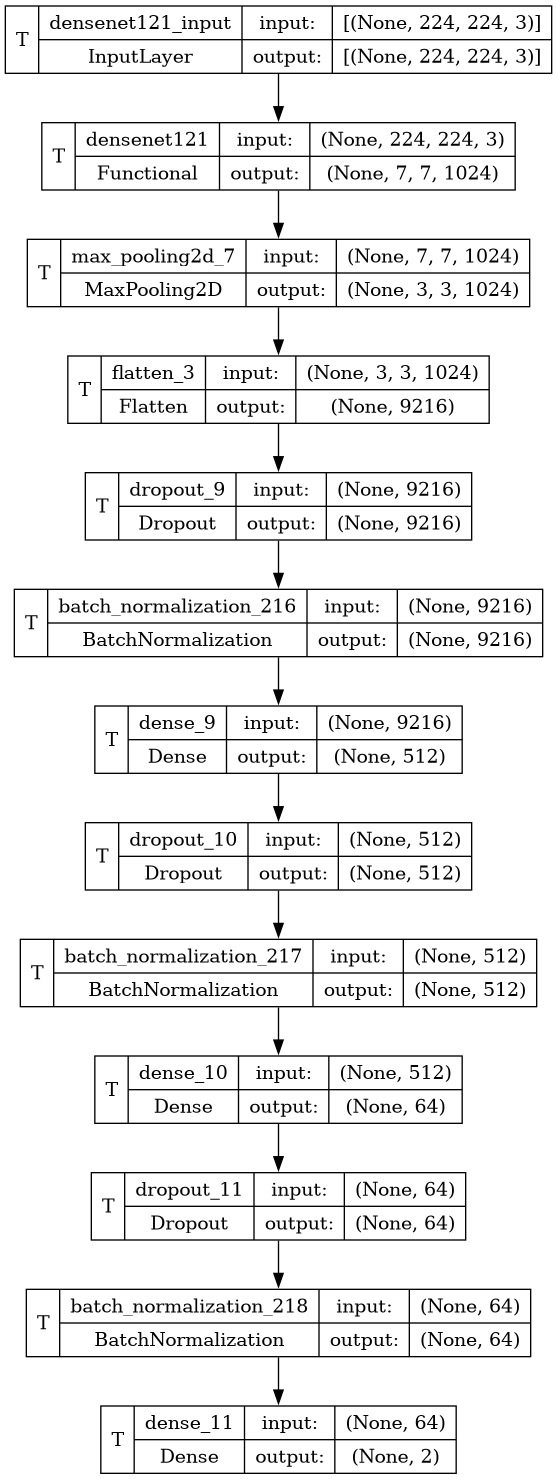

In [89]:
plot_model(DenseNet121_model, show_shapes = True, show_trainable = True)

In [90]:
# global parameters:
EPOCHS = 50
IMG_SHAPE = (224, 224, 3)
LR = 5e-4
OPTIMIZER = tf.keras.optimizers.legacy.Adamax(LR)
LOSS = SparseCategoricalCrossentropy()
METRICS = ['accuracy']

In [91]:
hist = DenseNet121_model.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, callbacks=[lr_scheduler]) 

Epoch 1/50
130/130 [==============================] - 38s 215ms/step - loss: 1.0429 - accuracy: 0.5243 - val_loss: 0.6487 - val_accuracy: 0.6022 - lr: 5.0000e-04
Epoch 2/50
130/130 [==============================] - 25s 195ms/step - loss: 0.9733 - accuracy: 0.5412 - val_loss: 0.6832 - val_accuracy: 0.6449 - lr: 4.6895e-04
Epoch 3/50
130/130 [==============================] - 25s 192ms/step - loss: 0.8330 - accuracy: 0.6052 - val_loss: 0.5360 - val_accuracy: 0.7416 - lr: 4.3982e-04
Epoch 4/50
130/130 [==============================] - 25s 194ms/step - loss: 0.7195 - accuracy: 0.6548 - val_loss: 0.5668 - val_accuracy: 0.7438 - lr: 4.1251e-04
Epoch 5/50
130/130 [==============================] - 25s 193ms/step - loss: 0.6681 - accuracy: 0.6957 - val_loss: 0.6255 - val_accuracy: 0.7596 - lr: 3.8689e-04
Epoch 6/50
130/130 [==============================] - 26s 196ms/step - loss: 0.6519 - accuracy: 0.7039 - val_loss: 0.5327 - val_accuracy: 0.7820 - lr: 3.6286e-04
Epoch 7/50
130/130 [========

Maximum Accuracy of Training set: 96.052
Minimum Loss of Trainig set: 0.11615127

Maximum Accuracy of Validation set: 84.494
Minimum Loss of Validation set: 0.42613503



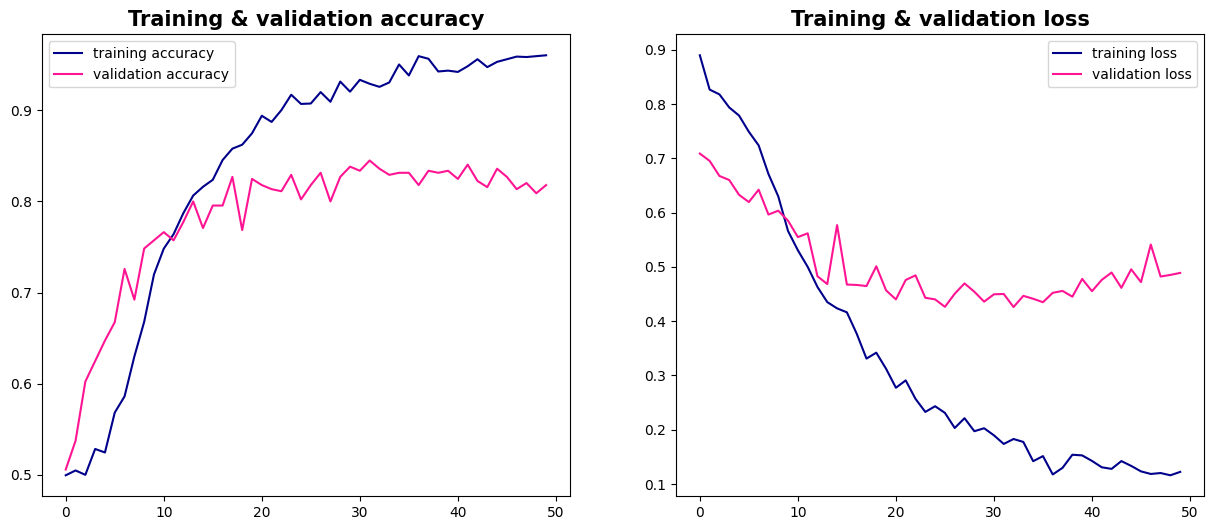

In [66]:
draw_plot(hist)

In [93]:
DenseNet121_model.compile(optimizer = tf.keras.optimizers.legacy.Adamax(0.0001), loss = LOSS, metrics = METRICS)

In [94]:
total_epochs = EPOCHS + 20

hist_fine = Xception_model.fit(train_generator, 
                      validation_data = validation_generator, 
                      epochs = total_epochs, 
                      initial_epoch = hist.epoch[-1] + 1)

Epoch 51/70
130/130 [==============================] - 26s 198ms/step - loss: 0.0940 - accuracy: 0.9639 - val_loss: 0.5203 - val_accuracy: 0.8202
Epoch 52/70
130/130 [==============================] - 25s 194ms/step - loss: 0.0996 - accuracy: 0.9668 - val_loss: 0.5153 - val_accuracy: 0.8382
Epoch 53/70
130/130 [==============================] - 25s 195ms/step - loss: 0.0808 - accuracy: 0.9764 - val_loss: 0.5184 - val_accuracy: 0.8292
Epoch 54/70
130/130 [==============================] - 26s 196ms/step - loss: 0.0803 - accuracy: 0.9735 - val_loss: 0.5216 - val_accuracy: 0.8360
Epoch 55/70
130/130 [==============================] - 26s 200ms/step - loss: 0.0649 - accuracy: 0.9793 - val_loss: 0.5803 - val_accuracy: 0.8225
Epoch 56/70
130/130 [==============================] - 26s 196ms/step - loss: 0.0608 - accuracy: 0.9798 - val_loss: 0.5551 - val_accuracy: 0.8292
Epoch 57/70
130/130 [==============================] - 25s 194ms/step - loss: 0.0635 - accuracy: 0.9812 - val_loss: 0.5254 -

Maximum Accuracy of Training set: 98.604
Minimum Loss of Trainig set: 0.05477737

Maximum Accuracy of Validation set: 83.820
Minimum Loss of Validation set: 0.51528567



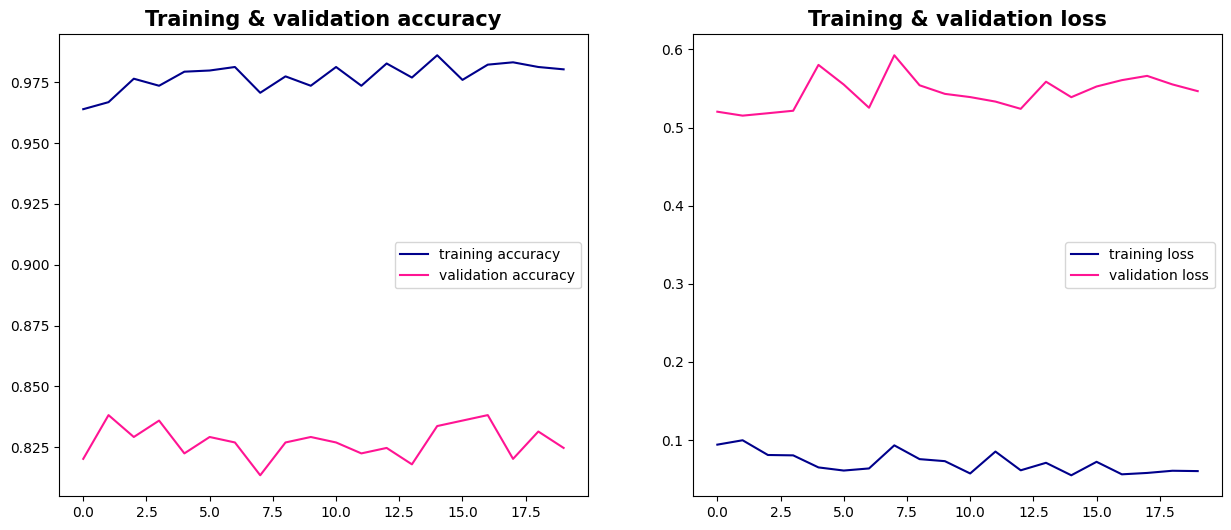

In [95]:
draw_plot(hist_fine)

## *Evaluation:*

In [96]:
loss, accuracy = DenseNet121_model.evaluate(test_generator)
print('Test accuracy :', accuracy * 100)

28/28 [==============================] - 4s 36ms/step - loss: 0.5215 - accuracy: 0.8161
Test accuracy : 81.61435127258301


In [97]:
# Generate predictions
predictions = DenseNet121_model.predict(test_generator)

28/28 [==============================] - 3s 33ms/step


In [98]:
y_pred = np.argmax(predictions, axis=1)
# y_test = np.argmax(y_test, axis=1)

## *Calculate classification report:*

In [99]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')

Precision: 0.816551
Recall: 0.816143


In [100]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.81      0.83      0.82       223
    fracture       0.83      0.80      0.81       223

    accuracy                           0.82       446
   macro avg       0.82      0.82      0.82       446
weighted avg       0.82      0.82      0.82       446



## *Compute confusion matrix:*

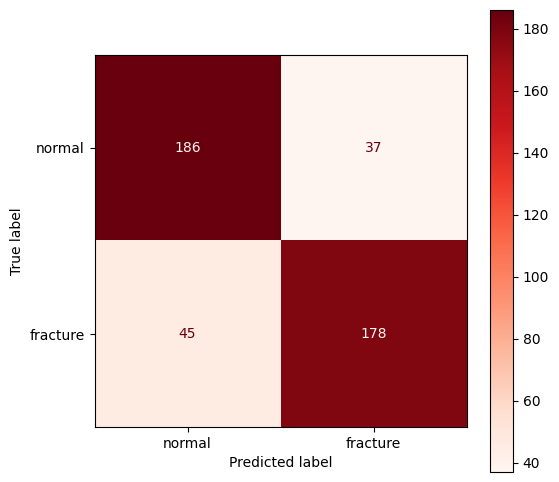

In [101]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['normal', 'fracture']

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(6, 6))
display.plot(ax=ax, values_format='.4g', cmap='Reds')
plt.show()

In [102]:
from sklearn.metrics import roc_auc_score

# Assuming y_true contains true labels and y_pred contains predicted probabilities
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

AUC: 0.8161434977578476


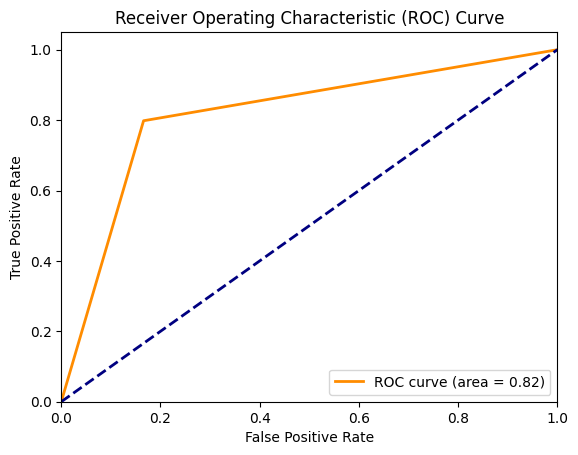

In [103]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true contains true labels and y_pred contains predicted probabilities
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## *Save Model:*

In [48]:
model.save('InceptionResNetV2.keras')

In [ ]:
model = keras.models.load_model('path/to/location.keras')

---

### DenseNet121

In [104]:
DenseNet121_model.trainable = False

In [105]:
DenseNet121_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 3, 3, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dropout_9 (Dropout)         (None, 9216)              0         
                                                                 
 batch_normalization_216 (B  (None, 9216)              36864     
 atchNormalization)                                              
                                                                 
 dense_9 (Dense)             (None, 512)              

In [106]:
layers_to_remove = ['dense_11']

layers_to_keep = [layer for layer in DenseNet121_model.layers if layer.name not in layers_to_remove]

DenseNet121_base_model = Sequential()

for layer in layers_to_keep:
    DenseNet121_base_model.add(layer)

In [107]:
DenseNet121_base_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 3, 3, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dropout_9 (Dropout)         (None, 9216)              0         
                                                                 
 batch_normalization_216 (B  (None, 9216)              36864     
 atchNormalization)                                              
                                                                 
 dense_9 (Dense)             (None, 512)              

### Xception

In [80]:
Xception_model.trainable = False

In [81]:
Xception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 3, 3, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_6 (Dropout)         (None, 18432)             0         
                                                                 
 batch_normalization_213 (B  (None, 18432)             73728     
 atchNormalization)                                              
                                                                 
 dense_6 (Dense)             (None, 512)              

In [82]:
layers_to_remove = ['dense_8']

layers_to_keep = [layer for layer in Xception_model.layers if layer.name not in layers_to_remove]

Xception_base_model = Sequential()

for layer in layers_to_keep:
    Xception_base_model.add(layer)

In [83]:
Xception_base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 3, 3, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_6 (Dropout)         (None, 18432)             0         
                                                                 
 batch_normalization_213 (B  (None, 18432)             73728     
 atchNormalization)                                              
                                                                 
 dense_6 (Dense)             (None, 512)              

### InceptionResNetV2

In [52]:
InceptionResNetV2_model.trainable = False

In [53]:
InceptionResNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 1536)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 batch_normalization_203 (B  (None, 6144)              24576     
 atchNormalization)                                              
                                                        

In [54]:
layers_to_remove = ['dense_2']

layers_to_keep = [layer for layer in InceptionResNetV2_model.layers if layer.name not in layers_to_remove]

InceptionResNetV2_base_model = Sequential()

for layer in layers_to_keep:
    InceptionResNetV2_base_model.add(layer)

In [55]:
InceptionResNetV2_base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 1536)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 batch_normalization_203 (B  (None, 6144)              24576     
 atchNormalization)                                              
                                                      

In [108]:
def build_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)

    out1 = Xception_base_model(input_img)
    out2 = DenseNet121_base_model(input_img)
    out3 = InceptionResNetV2_base_model(input_img)

    merged = concatenate([out1, out2, out3])
    
    # Output
    dense1_out = Dense(64, 'relu')(merged)
    drop1_out = Dropout(0.4)(dense1_out)
    bn1_out = BatchNormalization()(drop1_out)
    dense2_out = Dense(16, 'relu')(bn1_out)
    drop2_out = Dropout(0.3)(dense2_out)
    bn2_out = BatchNormalization()(drop2_out)
    
    output = Dense(len(classes), activation='softmax')(bn2_out)

    model1 = tf.keras.Model(inputs=input_img, outputs=output)

    return model1

model = build_model(IMG_SHAPE)
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [109]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 64)                   3040804   ['input_4[0][0]']             
                                                          0                                       
                                                                                                  
 sequential_6 (Sequential)   (None, 64)                   1182860   ['input_4[0][0]']             
                                                          8                                       
                                                                                              

In [110]:
len(model.trainable_variables)

10

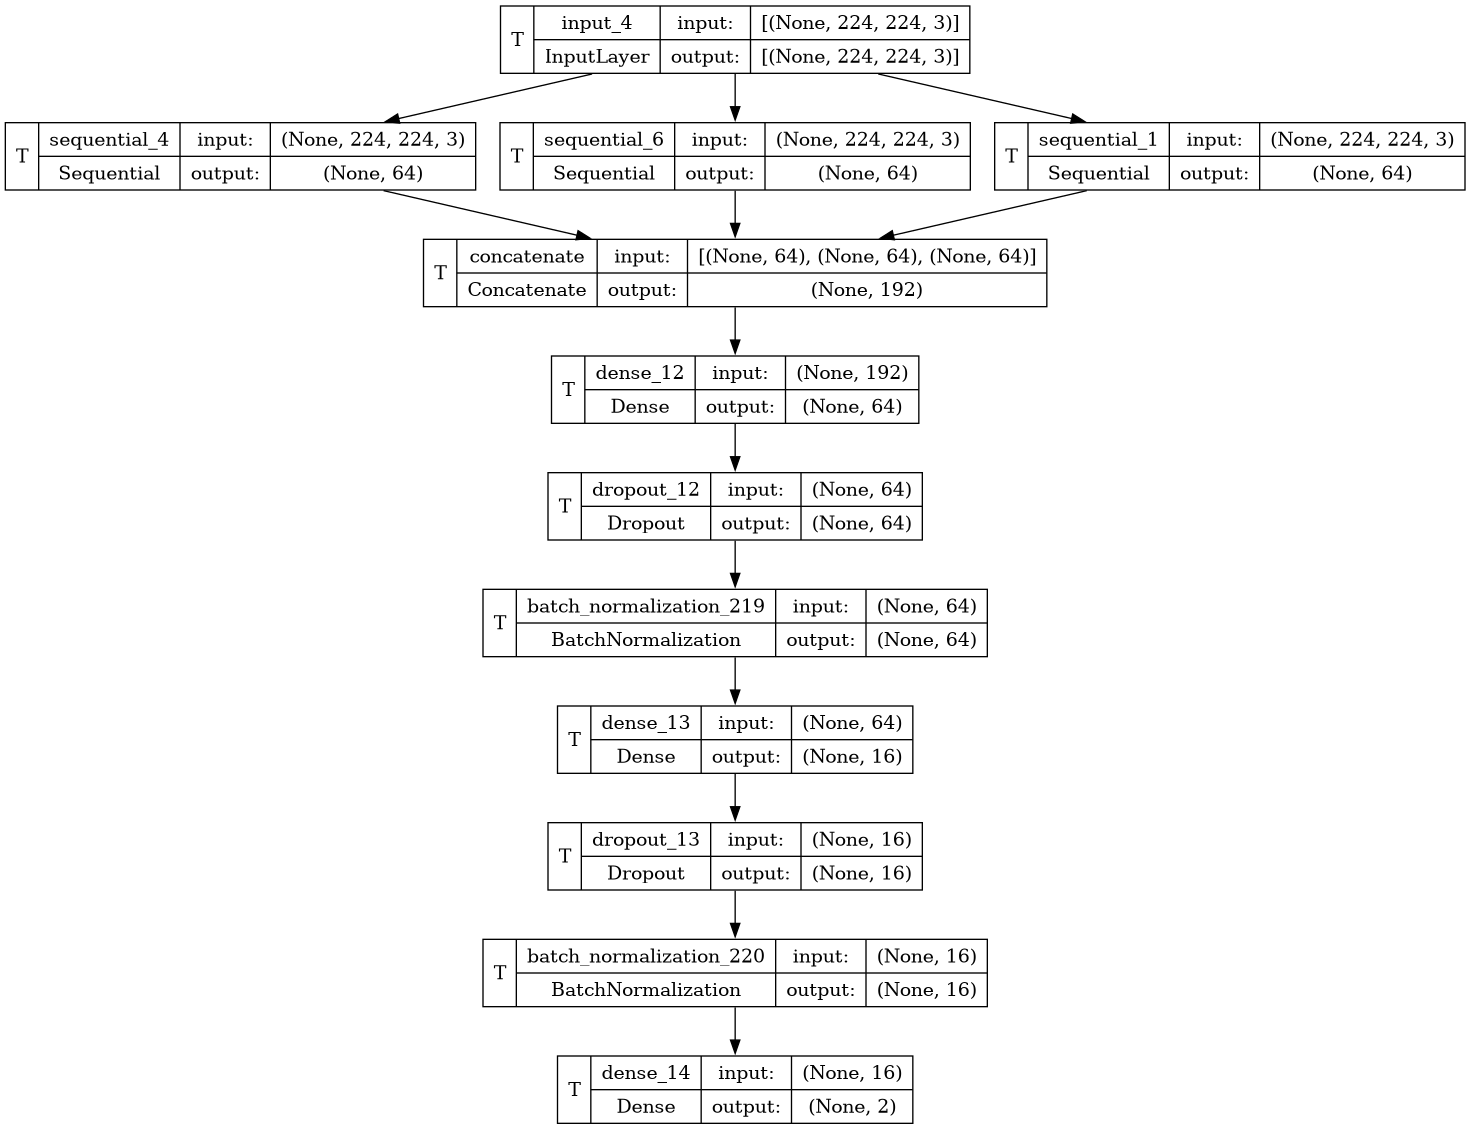

In [111]:
plot_model(model, show_shapes = True, show_trainable = True)

In [112]:
# global parameters:
EPOCHS = 50
IMG_SHAPE = (224, 224, 3)
LR = 5e-4
OPTIMIZER = tf.keras.optimizers.legacy.Adamax(LR)
LOSS = SparseCategoricalCrossentropy()
METRICS = ['accuracy']

In [113]:
hist = model.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, callbacks=[lr_scheduler]) 

Epoch 1/50
130/130 [==============================] - 60s 286ms/step - loss: 0.7224 - accuracy: 0.6586 - val_loss: 0.3736 - val_accuracy: 0.8494 - lr: 5.0000e-04
Epoch 2/50
130/130 [==============================] - 31s 241ms/step - loss: 0.4046 - accuracy: 0.8195 - val_loss: 0.3366 - val_accuracy: 0.8427 - lr: 4.6895e-04
Epoch 3/50
130/130 [==============================] - 31s 234ms/step - loss: 0.3001 - accuracy: 0.8705 - val_loss: 0.3233 - val_accuracy: 0.8494 - lr: 4.3982e-04
Epoch 4/50
130/130 [==============================] - 30s 233ms/step - loss: 0.2290 - accuracy: 0.9153 - val_loss: 0.3207 - val_accuracy: 0.8517 - lr: 4.1251e-04
Epoch 5/50
130/130 [==============================] - 30s 234ms/step - loss: 0.2005 - accuracy: 0.9278 - val_loss: 0.3185 - val_accuracy: 0.8562 - lr: 3.8689e-04
Epoch 6/50
130/130 [==============================] - 31s 237ms/step - loss: 0.1707 - accuracy: 0.9442 - val_loss: 0.3140 - val_accuracy: 0.8674 - lr: 3.6286e-04
Epoch 7/50
130/130 [========

Maximum Accuracy of Training set: 98.941
Minimum Loss of Trainig set: 0.04888432

Maximum Accuracy of Validation set: 87.640
Minimum Loss of Validation set: 0.31401715



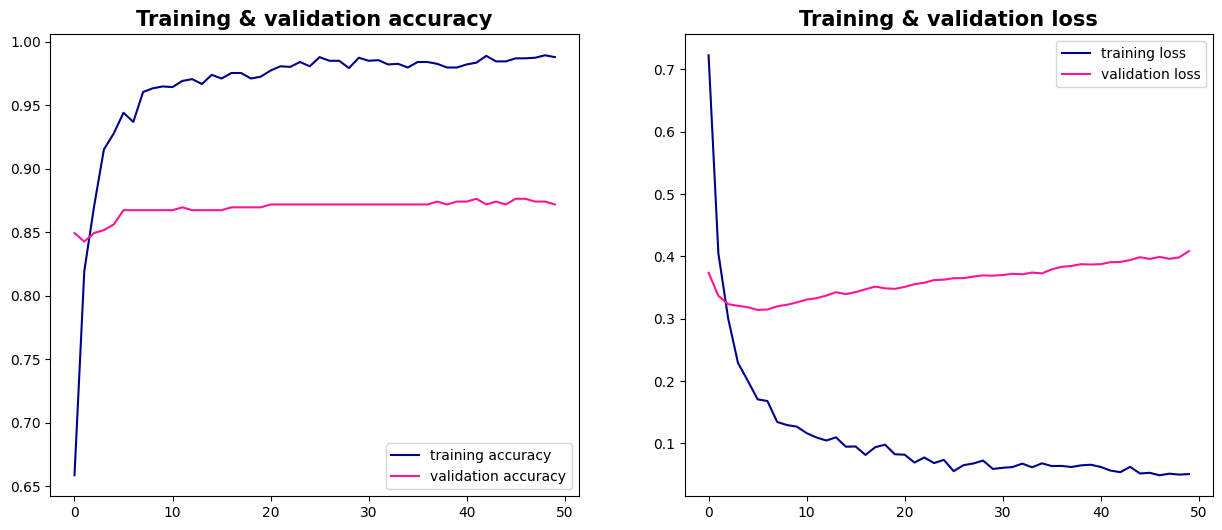

In [114]:
draw_plot(hist)

## *Evaluation:*

In [115]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy * 100)

28/28 [==============================] - 4s 135ms/step - loss: 0.5025 - accuracy: 0.8655
Test accuracy : 86.5470826625824


In [116]:
# Generate predictions
predictions = model.predict(test_generator)

28/28 [==============================] - 10s 124ms/step


In [117]:
y_pred = np.argmax(predictions, axis=1)
# y_test = np.argmax(y_test, axis=1)

## *Calculate classification report:*


In [118]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')

Precision: 0.871325
Recall: 0.865471


In [119]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.82      0.93      0.87       223
    fracture       0.92      0.80      0.86       223

    accuracy                           0.87       446
   macro avg       0.87      0.87      0.86       446
weighted avg       0.87      0.87      0.86       446



## *Compute confusion matrix:*


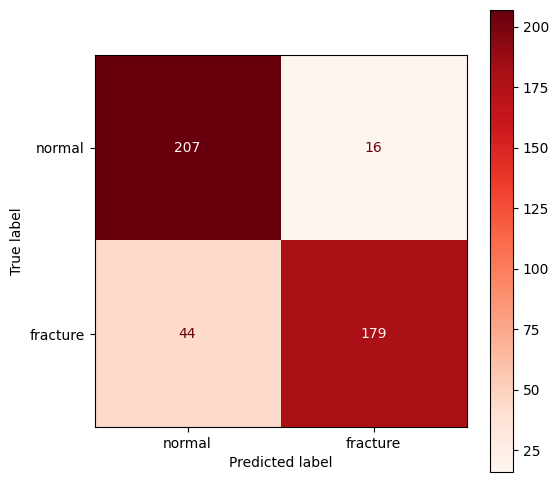

In [120]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['normal', 'fracture']

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(6, 6))
display.plot(ax=ax, values_format='.4g', cmap='Reds')
plt.show()

In [121]:
from sklearn.metrics import roc_auc_score

# Assuming y_true contains true labels and y_pred contains predicted probabilities
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

AUC: 0.8654708520179372


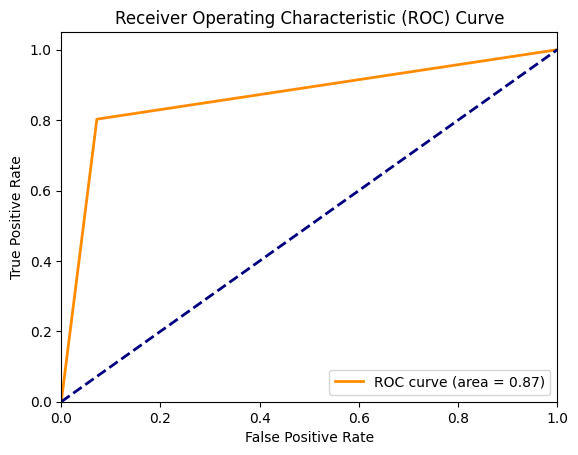

In [122]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true contains true labels and y_pred contains predicted probabilities
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()